## 

# PINN

##  $\frac{dy}{dx} = sin(x); \qquad BC : y(0) = 1; \\
Analytical Solution: y = -cos(x) + 2$



In [2]:
import torch
import torch.nn as nn
import numpy as np

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1) 
        )

    def forward(self, x):
        y = self.net(x)
        return y

model = PINN()

def fwd_gradients(Y, x):
    dummy = torch.ones_like(Y, requires_grad=True)

    Y_x = torch.autograd.grad(Y, x, grad_outputs=dummy, create_graph=True)[0]
    # Y_x = torch.autograd.grad(G, dummy, create_graph=True)[0]
    return Y_x
    
# Loss function combining ODE and boundary condition
def loss_func(x_data, x_bc, y_bc):
    x_data.requires_grad = True
    
    y_pred = model(x_data)
    # dy_dx_pred = torch.autograd.grad(y_pred, x_data, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    dy_dx_pred = fwd_gradients(y_pred, x_data)
    loss_ode = torch.mean((dy_dx_pred - torch.sin(x_data))**2)  # ODE residual

    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc_pred - y_bc)**2)            # Boundary condition residual

    return loss_ode + loss_bc

# Training setup
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
num_epochs = 4001

# Sample data points (can be increased for better accuracy)
x_data = torch.rand(500, 1)*np.pi*4  

x_bc = torch.tensor([[0.0]])
y_bc = torch.tensor([[1.0]])

# Training loop
Loss = []
for epoch in range(num_epochs):
    loss = loss_func(x_data, x_bc, y_bc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    Loss.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}") 
        


Epoch 0, Loss: 1.57642651
Epoch 100, Loss: 0.32414001
Epoch 200, Loss: 0.13746518
Epoch 300, Loss: 0.00228335
Epoch 400, Loss: 0.00144740
Epoch 500, Loss: 0.00108894
Epoch 600, Loss: 0.00102098
Epoch 700, Loss: 0.00071726
Epoch 800, Loss: 0.00057914
Epoch 900, Loss: 0.00048715
Epoch 1000, Loss: 0.00037297
Epoch 1100, Loss: 0.00038080
Epoch 1200, Loss: 0.00028185
Epoch 1300, Loss: 0.00200223
Epoch 1400, Loss: 0.00288077
Epoch 1500, Loss: 0.00019119
Epoch 1600, Loss: 0.00036355
Epoch 1700, Loss: 0.00016258
Epoch 1800, Loss: 0.00014705
Epoch 1900, Loss: 0.00013576
Epoch 2000, Loss: 0.00014431
Epoch 2100, Loss: 0.00012233
Epoch 2200, Loss: 0.00014750
Epoch 2300, Loss: 0.00380619
Epoch 2400, Loss: 0.00031960
Epoch 2500, Loss: 0.00031204
Epoch 2600, Loss: 0.00046957
Epoch 2700, Loss: 0.00322811
Epoch 2800, Loss: 0.00006588
Epoch 2900, Loss: 0.00006840
Epoch 3000, Loss: 0.00010279
Epoch 3100, Loss: 0.00164313
Epoch 3200, Loss: 0.00125114
Epoch 3300, Loss: 0.00007793
Epoch 3400, Loss: 0.000093

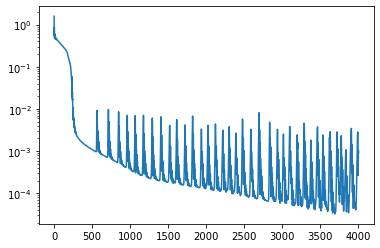

In [4]:

import matplotlib.pyplot as plt
Loss = np.array(Loss)
plt.plot(Loss)
plt.yscale("log")

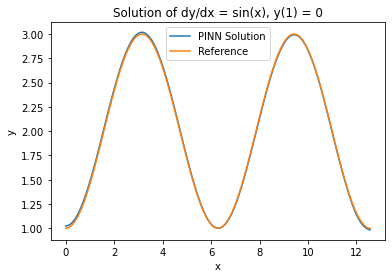

In [5]:
import matplotlib.pyplot as plt
x_plot = torch.linspace(0, 4*np.pi, 100).unsqueeze(-1)  # Points for plotting solution

y_plot = model(x_plot).detach().numpy()# Detach to avoid calculating gradients during plotting

y_true = -np.cos(x_plot) + 2

plt.figure()
plt.plot(x_plot, y_plot, label='PINN Solution')
plt.plot(x_plot, y_true, label='Reference')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of dy/dx = sin(x), y(1) = 0')
plt.legend()
plt.show()

## Wave equation: $\frac{du}{dt} + c\frac{du}{dx} = 0$

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, t):
        u = self.net(torch.cat([x,t], dim=1))
        return u
    
model = PINN()

def pde(x,t):
    x.requires_grad=True
    t.requires_grad=True
    u = model(x,t)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = torch.mean((u_t + u_x)**2)
    return residual

#Domain Size
xmin, xmax = -1.0, 2.0
tmin, tmax = 0.0, 1.0


# Residual Points
x_r, t_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(tmax-tmin) + tmin
x_r = x_r.view(-1,1)
t_r = t_r.view(-1,1)


# Initial condition
def initial_func(x):
    return torch.tanh(50*x)

#Initial points
x_init = torch.rand(500)*(xmax-xmin) + xmin
x_init = x_init.view(-1,1)
t_init = torch.zeros_like(x_init).view(-1,1)

u_init = initial_func(x_init)

def init_condition(x,t,u):
    u_pred = model(x,t)
    return torch.mean((u - u_pred)**2) # return initial loss

# Boundary points
t_bc_ = torch.linspace(tmin, tmax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(t_bc_).view(-1,1)
x_right_bc = xmax*torch.ones_like(t_bc_).view(-1,1)

u_left = -1*torch.ones_like(x_left_bc).view(-1,1)
u_right = 1*torch.ones_like(x_left_bc).view(-1,1)


t_bc = torch.cat([t_bc_,t_bc_], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc], dim=0)
u_bc = torch.cat([u_left,u_right], dim=0)

def bc_condition(x,t,u):
    u_pred = model(x,t)
    return torch.mean((u - u_pred)**2) # return boundary loss


# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_init, t_init, u_init, x_bc, t_bc, u_bc, x_r, t_r):

    initial_loss = init_condition(x_init, t_init, u_init)
    
    boundary_loss = init_condition(x_bc, t_bc, u_bc)
    
    pde_loss = pde(x_r, t_r)

    return pde_loss + boundary_loss + initial_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001


# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_init, t_init, u_init, x_bc, t_bc, u_bc, x_r, t_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}") 


Epoch 0, Loss: 1.65667188
Epoch 100, Loss: 0.19424072
Epoch 200, Loss: 0.07331313
Epoch 300, Loss: 0.03787279
Epoch 400, Loss: 0.02051486
Epoch 500, Loss: 0.01234891
Epoch 600, Loss: 0.00800972
Epoch 700, Loss: 0.00545278
Epoch 800, Loss: 0.00382948
Epoch 900, Loss: 0.00272106
Epoch 1000, Loss: 0.00193718
Epoch 1100, Loss: 0.00138392
Epoch 1200, Loss: 0.00099561
Epoch 1300, Loss: 0.00072361
Epoch 1400, Loss: 0.00053274
Epoch 1500, Loss: 0.00039795
Epoch 1600, Loss: 0.00030178
Epoch 1700, Loss: 0.00023237
Epoch 1800, Loss: 0.00018174
Epoch 1900, Loss: 0.00014452
Epoch 2000, Loss: 0.00011700
Epoch 2100, Loss: 0.00009654
Epoch 2200, Loss: 0.00008120
Epoch 2300, Loss: 0.00006958
Epoch 2400, Loss: 0.00006062
Epoch 2500, Loss: 0.00005357
Epoch 2600, Loss: 0.00004789
Epoch 2700, Loss: 0.00004321
Epoch 2800, Loss: 0.00003925
Epoch 2900, Loss: 0.00003584
Epoch 3000, Loss: 0.00003305


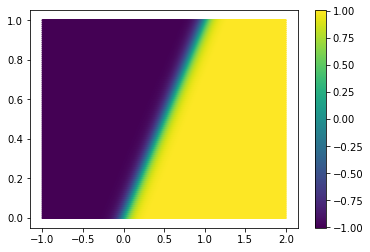

In [26]:
# data preparation
x_r, t_r = torch.linspace(xmin,xmax,1000), torch.linspace(tmin,tmax,100)
x_r, t_r = torch.meshgrid(x_r,t_r)
x_r = x_r.reshape(-1,1)
t_r = t_r.reshape(-1,1)

#prediction
u = model(x_r,t_r)
x_r = x_r.detach().numpy()
t_r = t_r.detach().numpy()
u = u.detach().numpy()

plt.figure()
plt.scatter(x_r,t_r,c=u, s= 0.5)
plt.colorbar()
plt.show()

## Heat equation $\frac{\partial ^2 T}{\partial x^2} + \frac{\partial ^2 T}{\partial y^2} =0 ;\\ 
BC : T(0,y) = T(1,y) = T(x,0) = 0 \quad \& \quad T(x,1) = 1$

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# pde_loss = pde(x_r, y_r)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# boundary_loss = bc_condition(x_bc,y_bc,T_bc)

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + 5*boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 6001


# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}") 

Epoch 0, Loss: 1.58058846
Epoch 100, Loss: 0.47226989
Epoch 200, Loss: 0.34947559
Epoch 300, Loss: 0.15954952
Epoch 400, Loss: 0.13701706
Epoch 500, Loss: 0.12278617
Epoch 600, Loss: 0.11553020
Epoch 700, Loss: 0.11160132
Epoch 800, Loss: 0.11013411
Epoch 900, Loss: 0.11060351
Epoch 1000, Loss: 0.10778008
Epoch 1100, Loss: 0.10668969
Epoch 1200, Loss: 0.10581468
Epoch 1300, Loss: 0.10479791
Epoch 1400, Loss: 0.10381648
Epoch 1500, Loss: 0.10257713
Epoch 1600, Loss: 0.10353440
Epoch 1700, Loss: 0.10044743
Epoch 1800, Loss: 0.09942108
Epoch 1900, Loss: 0.09911197
Epoch 2000, Loss: 0.09755465
Epoch 2100, Loss: 0.09658696
Epoch 2200, Loss: 0.09591548
Epoch 2300, Loss: 0.09484150
Epoch 2400, Loss: 0.09495559
Epoch 2500, Loss: 0.09280223
Epoch 2600, Loss: 0.09160406
Epoch 2700, Loss: 0.09060028
Epoch 2800, Loss: 0.08967314
Epoch 2900, Loss: 0.08868181
Epoch 3000, Loss: 0.08852973
Epoch 3100, Loss: 0.08708179
Epoch 3200, Loss: 0.08624055
Epoch 3300, Loss: 0.08558569
Epoch 3400, Loss: 0.084739

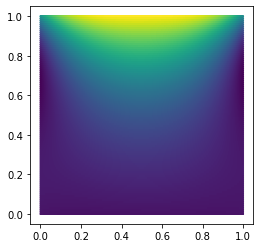

In [5]:
# data preparation
x_r, y_r = torch.linspace(xmin,xmax,1000), torch.linspace(ymin,ymax,100)
x_r, y_r = torch.meshgrid(x_r,y_r)
x_r = x_r.reshape(-1,1)
y_r = y_r.reshape(-1,1)

#prediction
u = model(x_r,y_r)
x_r = x_r.detach().numpy()
t_r = y_r.detach().numpy()
u = u.detach().numpy()

plt.figure(figsize=([4,4]))
plt.scatter(x_r,t_r,c=u, s= 0.5)
plt.show()